# Base model

In eerste instantie wordt een naive voorspelling gemaakt voor de bond markt. Het doel hiervan is om een benchmark te hebben waarmee de andere modellen kunnen worden vergeleken. We voorspellen voor 1 bond voor 10 dagen vooruit wat de bond prijs gaat doen. Idealiter zouden we de prijsontwikkeling van meerdere (alle) staatsobligaties tegelijk willen voorspellen, zodat het model op 1 moment kan aangeven welke bond een betere investering zou zijn. Maar 1 stap tegelijk.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import matplotlib.pyplot as plt
sys.path.insert(0, "..")
from src.data import make_dataset
from src.models import window, evaluate, base_model
from pathlib import Path
datadir = Path("../data/raw")

import tensorflow as tf
import numpy as np

In [2]:
df_price = make_dataset.read_pkl('price')
isin = "DE0001102374" # 10 Years NL Bond, maturity 2025 0.5% coupon
df_isin = df_price[df_price['reference_identifier'] == isin]
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()

2022-01-14 14:27:06.994 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed price data


<AxesSubplot:xlabel='rate_dt'>

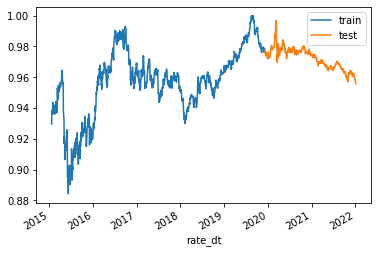

In [3]:
series = df_isin['mid']
split = math.floor(len(series) * .70)

# Train test split
train = series[:split]
norm = max(train)
test = series[split:]
train = train / norm
test = test / norm
train.plot(label = "train",legend=True)
test.plot(label ="test",legend=True)

In [4]:
(train.shape, test.shape)

((1245,), (534,))

In [5]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [6]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32]), TensorShape([32, 10]))

In [7]:
# This needs to move somewhere else...

maelist = []
for x, y in train_set:      
    x = x[:, -1] # get the last value of every batch
    size = tf.size(x) # this will be the batchsize, so mostly 32
    yhat = tf.broadcast_to(tf.reshape(x, [size,1]), [size, horizon]) # broadcast
    mae = np.mean(np.abs(yhat - y)) # calculate mae
    maelist.append(mae)
norm = np.mean(maelist)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)


0.004074368742107603


In [8]:
# 1 step naive prediction
y, yhat = base_model.naivepredict(train.values)
norm = evaluate.mae(y, yhat)
norm, evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.0017166150484410488, 6.262746686111532e-06, 1.003087633997175)

Een eenvoudig referentie model

In [9]:
%load_ext tensorboard

In [10]:
result = {}

In [11]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = Sequential([    
        tfl.Reshape((window_size, 1)),
        tfl.SimpleRNN(1),
        tfl.Dense(horizon)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)


In [12]:

for lr in [1e-2, 1e-3, 1e-4]:
    name = f"simpleRNN_Adam{lr}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)    
    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print('lr:', lr, model.evaluate(valid_set))

16/16 [==============================] - 0s 21ms/step - loss: 5.1689e-05 - mae: 0.0060 - smae: 1.4686
lr: 0.01 [5.168940333533101e-05, 0.00598348630592227, 1.4685677289962769]
16/16 [==============================] - 0s 15ms/step - loss: 2.1308e-05 - mae: 0.0035 - smae: 0.8637
lr: 0.001 [2.1308213035808876e-05, 0.003518983954563737, 0.8636881113052368]
16/16 [==============================] - 0s 16ms/step - loss: 3.5460e-05 - mae: 0.0046 - smae: 1.1340
lr: 0.0001 [3.546015432220884e-05, 0.004620345775038004, 1.1340028047561646]


In [19]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17560), started 1:43:13 ago. (Use '!kill 17560' to kill it.)

Het blijkt moeilijk om de naive voorspelling te verbeteren. Een hogere learning rate is zeker in het begin nodig. Na max 10 epochs is het model dan ook wel uitgeleerd en kunnen we waarschijnlijk beter met een lagere learning rate verder gaan.

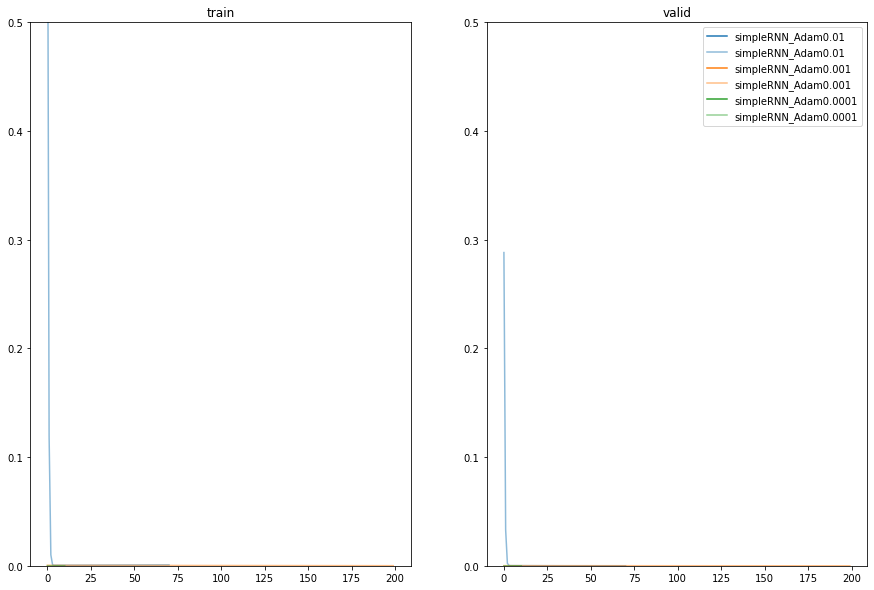

In [14]:
from src.models import evaluate
evaluate.plot_results(result, ymax = 0.05, subset="simple")

In [23]:
result.keys()

dict_keys(['simpleRNN_Adam0.01', 'simpleRNN_Adam0.001', 'simpleRNN_Adam0.0001', 'simpleRNN_Adam_rlr'])

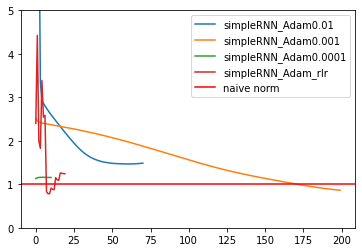

In [56]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="simple")

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

name = f"simpleRNN_Adam_rlr"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)
lr = 0.01

reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)
model.compile(loss="mse", optimizer=Adam(learning_rate = lr), metrics=["mae", smae])                              
result[name] = model.fit(train_set, epochs=200, validation_data=valid_set, callbacks=[reduce_lr, early_stop, tb], verbose=0)

Ook wanneer we de learning rate reduceren wordt het model niet veek beter. Na 7 epochs is het resultaat wel beter dan het naive model.

Uitbreiden van het model

In [33]:
opt = tf.keras.optimizers.get('Adam')
opt.learning_rate = 0.1
opt.get_config()

{'name': 'Adam',
 'learning_rate': 0.1,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [34]:
from src.models import hyper
from tqdm import tqdm

config = {
    'window'    :   32,
    'filters'   :   16,
    'kernel'    :   4,    
    'units'     :   16,    
    'hidden'    :   1, 
    'horizon'   :   horizon,
    'type'      :   'RNN'    
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"16_RNN_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)
    
    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])

    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

16/16 [==============================] - 0s 19ms/step - loss: 4.0680e-05 - mae: 0.0052 - mape: 0.5361 - smae: 1.2808


 33%|███▎      | 1/3 [03:40<07:21, 220.60s/it]

opt: Adam [4.06798098993022e-05, 0.005218468140810728, 0.5361066460609436, 1.28080415725708]
16/16 [==============================] - 0s 19ms/step - loss: 1.2448e-04 - mae: 0.0088 - mape: 0.9052 - smae: 2.1685


 67%|██████▋   | 2/3 [18:13<10:04, 604.38s/it]

opt: SGD [0.00012448466441128403, 0.00883533526211977, 0.9052023887634277, 2.1685163974761963]
16/16 [==============================] - 0s 16ms/step - loss: 4.9335e-05 - mae: 0.0058 - mape: 0.5969 - smae: 1.4210


100%|██████████| 3/3 [21:51<00:00, 437.04s/it]

opt: RMSprop [4.933525269734673e-05, 0.005789535120129585, 0.5969147682189941, 1.4209648370742798]


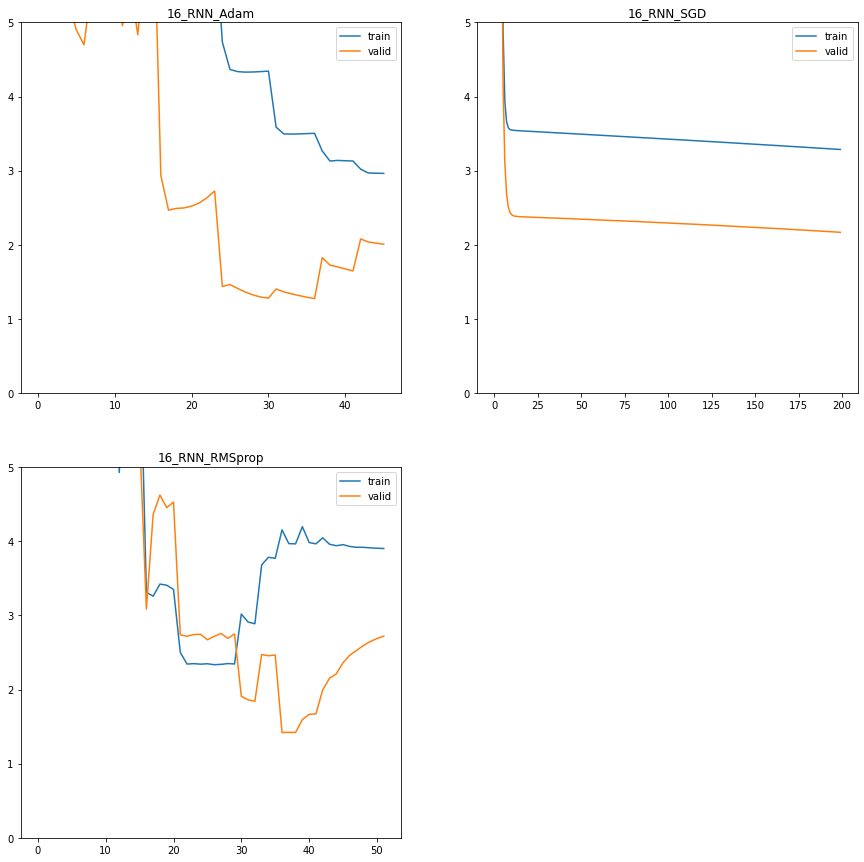

In [51]:
evaluate.plot_results(result, ymax = 5, subset="16",grid = True, measure = 'smae')

Het wordt er niet beter op. RMSprop lijkt iets beter te leren. Opvallend verder dat de modellen het allemaal beter doen op de validatie set dan op de training set.

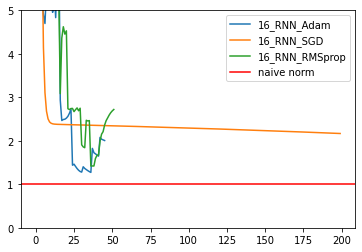

In [55]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="16")

Deeper models with memory...

In [57]:
reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)

config = {
    "window" : window_size,
    "filters" : 64,
    "kernel" : 3,
    "type" : "GRU",
    "units" : 128,
    "hidden" : 4,
    "horizon" : horizon,
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"GRU_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)

    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])
    
    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

16/16 [==============================] - 0s 11ms/step - loss: 9.6330e-06 - mae: 0.0021 - mape: 0.2188 - smae: 0.5236


 33%|███▎      | 1/3 [00:22<00:45, 22.73s/it]

opt: Adam [9.632968613004778e-06, 0.0021332423202693462, 0.21884717047214508, 0.5235761404037476]
16/16 [==============================] - 0s 20ms/step - loss: 1.9097e-05 - mae: 0.0033 - mape: 0.3424 - smae: 0.8203
opt:

 67%|██████▋   | 2/3 [02:46<01:33, 93.72s/it]

 SGD [1.9096556570730172e-05, 0.003342060837894678, 0.34235867857933044, 0.8202646970748901]
16/16 [==============================] - 0s 12ms/step - loss: 1.1529e-04 - mae: 0.0087 - mape: 0.8991 - smae: 2.1367


100%|██████████| 3/3 [03:07<00:00, 62.54s/it]

opt: RMSprop [0.00011528975301189348, 0.0087055005133152, 0.8991245627403259, 2.136650323867798]


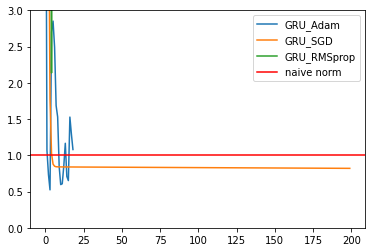

In [60]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=3.0, subset="GRU")

Modellen met historie doen het aanzienlijk beter - zoals verwacht. De RMSprop optimizer lijkt het nu juist weer een stuk minder goed te doen.

In [61]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "window" : tune.randint(16, 52),
    "filters" : tune.randint(8, 32),
    "kernel" : 3,
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(64, 256, 16),
    "horizon" : 10,
}

In [62]:
analysis = hyper.hypertune(config)

Trial name,status,loc,filters,hidden,optimizer,type,units,window
wrapper_edaf0_00000,RUNNING,127.0.0.1:19228,11,3,RMSprop,GRU,144,48
wrapper_edaf0_00001,PENDING,,8,2,Adam,LSTM,192,42
wrapper_edaf0_00002,PENDING,,11,2,Adam,LSTM,96,21
wrapper_edaf0_00003,PENDING,,10,2,RMSprop,GRU,112,28
wrapper_edaf0_00004,PENDING,,11,2,RMSprop,GRU,240,23
wrapper_edaf0_00005,PENDING,,28,1,Adam,GRU,192,43
wrapper_edaf0_00006,PENDING,,19,3,Adam,GRU,112,36
wrapper_edaf0_00007,PENDING,,24,3,Adam,LSTM,80,25
wrapper_edaf0_00008,PENDING,,24,4,RMSprop,GRU,256,27
wrapper_edaf0_00009,PENDING,,29,4,RMSprop,GRU,208,22


 pid=19228) 2022-01-14 16:02:04,818	ERROR function_runner.py:268 -- Runner Thread raised error.
 pid=19228) Traceback (most recent call last):
 pid=19228)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 262, in run
 pid=19228)     self._entrypoint()
 pid=19228)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 330, in entrypoint
 pid=19228)     return self._trainable_func(self.config, self._status_reporter,
 pid=19228)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
 pid=19228)     return method(self, *_args, **_kwargs)
 pid=19228)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 597, in _trainable_f

Result for wrapper_edaf0_00000:
  date: 2022-01-14_16-02-04
  experiment_id: 53520f49b9e5423fbe047b5d4ef4646e
  hostname: Game-PC
  node_ip: 127.0.0.1
  pid: 19228
  timestamp: 1642172524
  trial_id: edaf0_00000
  


 pid=8932) 2022-01-14 16:02:08,110	ERROR function_runner.py:268 -- Runner Thread raised error.
 pid=8932) Traceback (most recent call last):
 pid=8932)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 262, in run
 pid=8932)     self._entrypoint()
 pid=8932)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 330, in entrypoint
 pid=8932)     return self._trainable_func(self.config, self._status_reporter,
 pid=8932)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
 pid=8932)     return method(self, *_args, **_kwargs)
 pid=8932)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 597, in _trainable_func
 pid=

KeyboardInterrupt: 

In [ ]:
config = analysis.get_best_config()
config

In [ ]:
window_size = config["window"]
horizon = config["horizon"]
train_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)
valid_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
)
opt = tf.keras.optimizers.get(config["optimizer"])
opt.momentum = 0.9
opt.learning_rate = 0.01
model = hyper.HyperRnn(config)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])

result["hypertuned"] = model.fit(
        train_set,
        epochs=150,
        validation_data=valid_set,
        callbacks=[reduce_lr, early_stop],
    )


In [ ]:
plt.figure(figsize=(8,8))
evaluate.naive(result, ylim=1.5)

In [ ]:
evaluate.plot_results(result, ymax = 0.1)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = horizon)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = 4)